### Dense Net on CIFAR" 

In [2]:
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

In [3]:
import tensorflow as tf

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### DATA

In [5]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10) 

170500096/170498071 [==============================] - 6s 0us/step


In [6]:
batch_size =50
num_filter = 35
dropout_rate = 0
num_classes = 10
l = 6
compression = 1.0

In [7]:
# Dense Block
def denseblock(input, num_filter = 12 , dropout_rate = 0.0):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter=12 , dropout_rate = 0.0):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    
    output = layers.Conv2D(filters=num_classes,kernel_size=(2,2),activation='softmax')(AvgPooling)

    flat = layers.Flatten()(output)
    return flat

In [8]:
dropout_rate=0
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(35, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, 35, dropout_rate)
First_Transition = transition(First_Block, 35, dropout_rate)

Second_Block = denseblock(First_Transition, 35, dropout_rate)
Second_Transition = transition(Second_Block, 35, dropout_rate)

Third_Block = denseblock(Second_Transition, 35, dropout_rate)
Third_Transition = transition(Third_Block, 35, dropout_rate)

Last_Block = denseblock(Third_Transition,  35, dropout_rate)
output = output_layer(Last_Block)

In [9]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 35)   945         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 35)   140         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 35)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
def conv_pixel(train, test):

	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	return train_norm, test_norm

X_train,X_test = conv_pixel(X_train,X_test)

### Data Augmentation

In [11]:
data_gen = ImageDataGenerator(
    rotation_range=22,
    width_shift_range=0.125,
    height_shift_range=0.125,
    horizontal_flip=True,
    fill_mode = 'nearest',
    zoom_range=0.01)
data_gen.fit(X_train)

In [12]:
X_train.shape

(50000, 32, 32, 3)

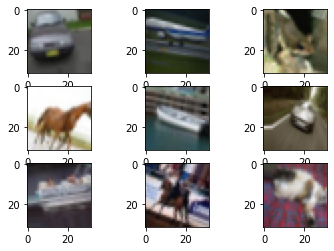

In [13]:
for X_batch, y_batch in data_gen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i], cmap=plt.get_cmap())
    plt.show()
    break

In [14]:
ls

drive/  sample_data/


In [15]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(), metrics=['accuracy'])

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience= 5,
                              min_lr=0.000001)
filepath = "drive/My Drive/best_model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')

callbacks = [checkpoint, reduce_lr]

In [17]:
history=model.fit_generator(data_gen.flow(X_train, y_train, batch_size=50),
                    steps_per_epoch = (len(X_train) /50), epochs=50, validation_data=(X_test, y_test),callbacks=callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
1000/1000 [==============================] - ETA: 0s - loss: 1.4667 - accuracy: 0.4679
Epoch 00001: val_loss improved from -inf to 1.62575, saving model to drive/My Drive/best_model.hdf5
1000/1000 [==============================] - 65s 65ms/step - loss: 1.4667 - accuracy: 0.4679 - val_loss: 1.6258 - val_accuracy: 0.4306 - lr: 0.0010
Epoch 2/50
1000/1000 [==============================] - ETA: 0s - loss: 1.0271 - accuracy: 0.6341
Epoch 00002: val_loss did not improve from 1.62575
1000/1000 [==============================] - 64s 64ms/step - loss: 1.0271 - accuracy: 0.6341 - val_loss: 1.1933 - val_accuracy: 0.6039 - lr: 0.0010
Epoch 3/50
1000/1000 [==============================] - ETA: 0s - loss: 0.8457 - accuracy: 0.7010
Epoch 00003: val_loss did not improve from 1.62575
1000/1000 [==============================] - 64s 64ms/step - loss: 0.8457 - accuracy: 0.7010 - val_loss: 0.8319 - val_accuracy: 0.71

## Observation 


1) Here i tried with variation of different values of number filters and conclusion was that the number of filters should be small.

2)I got accuracy as 94.21% and validation accuracy as 90.32 % after 50 epochs 

3) Reduce lr on plateau helped to reach the convergence in less number of epochs 

4) Data augmention helped to improve the results 